A **hard classification** is when we take an observation and predict which class it belongs to. For example, a bank could use someone's financial history (the observation) to predict whether or not they would pay back a loan. A doctor could take measurements of a tumor (the observation) to predict whether the tumor was malignant and needed to be removed. 

In contrast, a **soft classification** indicates the confidence the model has in its prediction. In giving a loan, a model might make the _hard_ classification that both clients would pay back a loan, but the _soft_ classification that client 1 has an 80% chance of paying the loan back, while client 2 has a 95% chance of paying the loan back.

If we have a soft classifier, we can make a hard classifier by picking a _threshold_: simply classify all observations with soft predictions above the threshold as the positive class, and those with soft predictions below the threshold as the negative class. For scikit-learn classifiers that calculate probabilities, this is how they work with a default threshold of 50%. Using probability as a threshold helps make your model more explainable as well -- you might decide that for a loan classifier, you only want to accept people that you are really confident about (e.g. those that have an 85% chance of higher of paying back a loan). For the tumor case, you might decide to have a doctor look at any tumor that has more than a 5% chance of being malignant.

While a probability is a convenient way to make a soft classification, all we really need is a score. This is easiest to explain for a binary classifier. Calling one of the cases the positive class, the only thing we need from the score is
> A higher score means the model is more confident that the observation belongs to the positive class

A well-known example of a score that _isn't_ a probability is a credit score. Usually between 300 and 850, the higher the credit score a person has, the more confidence a bank has that they will pay back a loan. We don't directly get an answer to the question "the probability that someone with a credit score of 620 pays back a loan is ....." (which presumably depeneds on things like size of the loan), but it does allow a bank to rank people it would like to give loans to. 

If we have access to a probability of belonging to the positive class, it is a great candidate for a score. Not only does a higher score mean the model is more confident in the observation, but we are also able to use the probabilities to determine things like our expected values. If we use our probabilities this way we have to be careful they are actually probabilities. Scikit-learn's `predict_proba` method promises probabilities, but often these are really just scores between 0 and 1, that sum to one!

## Beware of bad names

For many models in Scikit-learn, we have a `predict_proba` method. For each observation, `predict_proba` returns an array with the same number of columns as there are classes; and the "probability" that an observation is in class $i$ is found by looking at the $i$-th column. However, for many models, these are not really probabilities. Instead, they are scores that satisfy the following conditions:

1. Each "probability" is between 0 and 1,
2. When you sum the probabilities of an observation being in any particular class, they sum to 1.


## What makes something a probability?

Probability can be difficult to define. For example, if we make a rain predictor, and it tells us there is a 20% chance of rain today, what does that mean? How can we tell if it is correct or not? When checking the prediction, it will either rain (or it won't). The standard frequentist argument is if we take days that look similar to today, then on 20% of them it should rain, but then we get into arguments about how similar different days have to be in order to be grouped together. In even more extreme, such as predicting the outcome of elections, it is difficult to see how we could "repeat" the experiment to give meaning to the result.

In _The Signal and the Noise_, Nate Silver talks about this problem for weather forecasts in chapter 4. Instead of worrying about what makes days similar to one another, let's take a different approach. Look historically at all the days where our model made the prediction that it would rain 20% of the time. Out of _those_ days, what percentage of the time did it actually rain? If the answer is wildly different from 20%, then the model's probabilities are not doing a great job at actually estimating the probability.

In practice, we bin the probabilities, as there might only be one day where there is a probability of exactly `0.2000` of rain. If we take all the predictions between `17.5%` and `22.5%` and group them together in one bin, we would expect it to actually rain between `17.5%` and `22.5%` of the time.

This process of binning the prediction probabilities and comparing to the actual proportion of times it happened is called _calibration_. A _calibration curve_ plots the predicted probabilities against the actual rate of occurance.

### The weather example

Let's look at [this Kaggle dataset](https://www.kaggle.com/rtatman/did-it-rain-in-seattle-19482017) of whether or not it rained in Seattle. We will load the data into a dataframe:

In [1]:
#ignore
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import set_matplotlib_formats
%matplotlib inline

In [2]:
#ignore
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer

from sklearn.calibration import CalibratedClassifierCV, calibration_curve

set_matplotlib_formats('svg')

In [3]:
rain = pd.read_csv('seattleWeather_1948-2017.csv').dropna()
rain.head()

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


The precipitation column (`PRCP`) tells us how many inches of rain fell, and the `RAIN` column tells us if any rain at all fell. We shouldn't use "how much rain fell" to determine _if_ any rain fell, so we are just going to use the temperatures to predict whether or not there was rain that day.

In [4]:
features = rain[['TMIN', 'TMAX']]
target = rain.RAIN.astype(bool)
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42)

y_train.mean()

0.42774385470486925

We can also see that the data set is reasonable balanced (it rained on 42.8% of the days in the training set). 

Let's use a Naive Bayes Classifier and make hard predictions:

In [5]:
nb_rain = GaussianNB().fit(X_train, y_train)
accuracy = nb_rain.score(X_train, y_train)
print(f'The hard predictions were right {100*accuracy:5.2f}% of the time')

The hard predictions were right 67.17% of the time


What about the soft predictions? We can use the `predict_proba` method to get them. We are only interested in the probability we predict the positive case, so we are going to grab column 1:

In [6]:
predictions = nb_rain.predict_proba(X_train)[:, 1]

Plotting the distribution of probabilities:

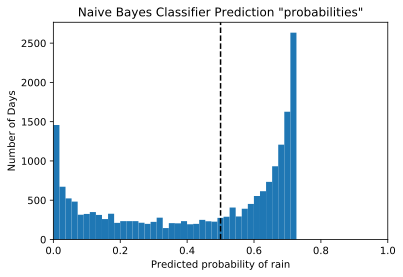

In [7]:
#ignore
plt.hist(predictions, bins=40)
plt.xlabel('Predicted probability of rain')
plt.ylabel('Number of Days')
plt.title('Naive Bayes Classifier Prediction "probabilities"')
plt.gca().axvline(0.5, ls='--', c='k')
plt.xlim(0, 1);

Here we see something interesting: even though our Naive Bayes model will make predictions greater than 50% (which means `nb_rain.predict(...)` would predict rain on those days), the probability never exceeds 70%. We can call `calibration_curve` to "bin" similar predicted probabilities together, and calculate what percentage of the time it actually rains in that bin:

In [8]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

predictions = nb_rain.predict_proba(X_train)[:, 1]
binned_true_p, binned_predict_p = calibration_curve(y_train, predictions, n_bins=10)

We can now plot the predicted probabilities against the actual probabilities:

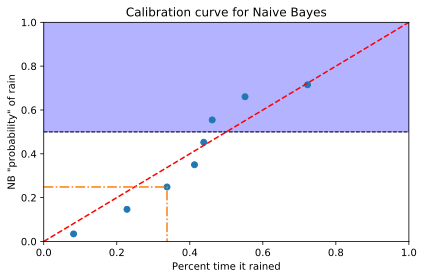

In [9]:
#ignore
predictions = nb_rain.predict_proba(X_train)[:, 1]
binned_true_p, binned_predict_p = calibration_curve(y_train, predictions, n_bins=10)
plt.plot(binned_true_p, binned_predict_p, 'o')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Percent time it rained')
plt.ylabel('NB "probability" of rain')
plt.title('Calibration curve for Naive Bayes')
plt.axhline(0.5, lw=1, ls='--', c='k');
plt.gca().axhspan(0.5, 1.0, alpha=0.3, color='blue')
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.plot([0, binned_true_p[2], binned_true_p[2]],
         [binned_predict_p[2], binned_predict_p[2], 0],
         '-.')

plt.tight_layout()

The highlighted point in the calibration curve tells us that when our classifier claimed the probability of raining was approximately 25%, it actually rained 33% of the time! Someone told the "probability" of rain was only 25% thinks they will get one time in four, but will actually get wet one time in three! The region shown in blue is the region where a "hard" classification (i.e. `nb_rain.predict`) would predict rain.

If our classifier was giving us good probabilities, the points would line up close to the red line. As an example, a random forest on the same dataset gives the following result:

In [10]:
rfc_rain = RandomForestClassifier(n_estimators=100, random_state=13).fit(X_train, y_train)
rfc_predict = rfc_rain.predict_proba(X_train)[:, 1]

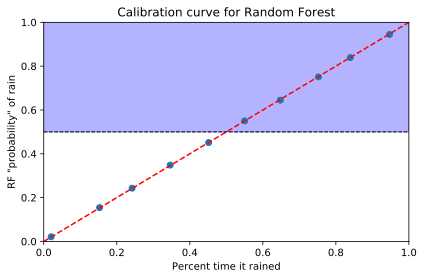

In [11]:
#ignore
binned_true_p, binned_predict_p = calibration_curve(y_train, rfc_predict, n_bins=10)
plt.plot(binned_true_p, binned_predict_p, 'o')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Percent time it rained')
plt.ylabel('RF "probability" of rain')
plt.title('Calibration curve for Random Forest')
plt.axhline(0.5, lw=1, ls='--', c='k');
plt.gca().axhspan(0.5, 1.0, alpha=0.3, color='blue')
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()

In this case, we see that our Random Forest's estimation of the probabilities are very reasonable!

For this example, Naive Bayes gave scores that _looked_ like probabilities, and were generated by `predict_proba` so they should be probabilities, but when we looked at our calibration curve we found that they were really just scores. The random forest `predict_proba` _in this case_ gave reasonable probabilities.

## Recalibration and Platt scaling

When a model's `predict_proba` method gives scores rather than probabilities, we can recalibrate the scores to make them closer to a probability. This process is called _Platt scaling_, and is implemented in Scikit-learn as `CalibratedClassifierCV`. In the weather example, we could apply Platt scaling to our Naive Bayes Classifier:

In [12]:
calibrated_nb_rain = CalibratedClassifierCV(nb_rain, cv=5, method='isotonic')
# Note we need to refit!
calibrated_nb_rain.fit(X_train, y_train);

We can now use `calibrated_nb_rain.predict_proba` to access the probabilities after recalibration. Note that we are doing this on the _test_ set, so this is data that hasn't been seen on training _or_ calibration:

In [13]:
calibrated_probs = calibrated_nb_rain.predict_proba(X_test)[:, 1]
binned_true_p, binned_predict_p = calibration_curve(y_test, calibrated_probs, n_bins=10)

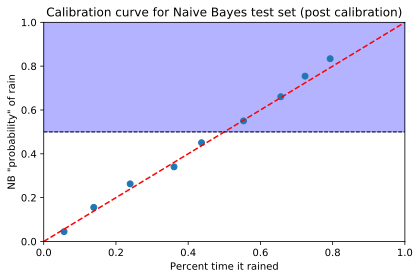

In [14]:
#ignore
plt.plot(binned_true_p, binned_predict_p, 'o')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Percent time it rained')
plt.ylabel('NB "probability" of rain')
plt.title('Calibration curve for Naive Bayes test set (post calibration)')
plt.axhline(0.5, lw=1, ls='--', c='k');
plt.gca().axhspan(0.5, 1.0, alpha=0.3, color='blue')
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()

These corrected probabilities are looking pretty good! Let's compare the no calibration and post-calibration models side-by-side on the test set:

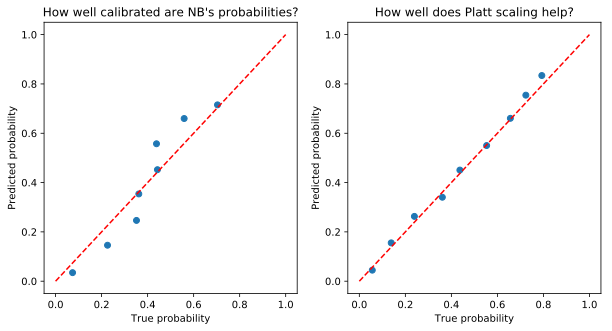

In [15]:
#ignore
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
predict_prob = nb_rain.predict_proba(X_test)[:, 1]
prob_true, prob_predict = calibration_curve(y_test, predict_prob, n_bins=10)

plt.plot(prob_true, prob_predict, 'o')
plt.plot([0,1], [0, 1], 'r--')

plt.xlabel('True probability')
plt.ylabel('Predicted probability')
plt.title('How well calibrated are NB\'s probabilities?');


plt.subplot(1,2,2)
predict_prob = calibrated_nb_rain.predict_proba(X_test)[:, 1]
prob_true, prob_predict = calibration_curve(y_test, predict_prob, n_bins=10)
plt.plot(prob_true, prob_predict, 'o')
plt.plot([0,1], [0, 1], 'r--')

# plt.tight_layout()
plt.xlabel('True probability')
plt.ylabel('Predicted probability')
plt.title('How well does Platt scaling help?');

One thing to be aware of is that (by default) `CalibratedClassifierCV` actually refits your model while calibrating. You can override this by setting `cv="prefit"`, but if you do this you need to make sure that you fit `CalibratedClassifierCV` on a different set of data than the set you trained your model on, i.e. you should split your data into _training_, _calibration_, and _test_ sets.

## Limitations of recalibration

The examples above show a really good probabilities out of the box (with Random Forest) and a huge improvement on probabilities for Naive Bayes. Random Forest doesn't always perform this well, and scaling cannot always make the probabilities "good". Let's look at a slightly more complicated problem where we would want accurate probabilities to calculate expected values: a loan payback dataset.

In [16]:
loans = pd.read_csv('lending_club_clean.csv')
loans.head()

,loan_amnt,annual_inc,open_acc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,term,grade,emp_length,home_ownership,purpose,defaulted
0,10000.0,49200.0,10.0,20.00,0.0,1.0,35.0,0.0,5598.0,21.00,37.0,0.0,36,C,10,RENT,other,False
1,3000.0,80000.0,15.0,17.94,0.0,0.0,38.0,0.0,27783.0,53.90,38.0,0.0,60,B,1,RENT,other,False
2,6000.0,84000.0,4.0,18.44,2.0,0.0,8.0,0.0,0.0,37.73,14.0,0.0,36,B,1,MORTGAGE,medical,False
3,5000.0,50004.0,14.0,13.97,3.0,0.0,20.0,0.0,4345.0,59.50,22.0,0.0,60,D,2,RENT,other,True
4,5000.0,24044.0,8.0,11.93,0.0,0.0,45.0,0.0,2224.0,29.30,16.0,0.0,36,A,2,RENT,debt_consolidation,False


For this problem, we are interested in predicting the default rate (i.e. the `defaulted` column). Because the goal is just to look at the scaling, we simplify our features by making the following transformations:
* Drop all categorical features (`home_ownership`, `purpose`, `grade`)
* Binarize the terms (only 3 year and 5 year terms)
* Binarize the banckruptcies (only 2 people have more than 1 bankruptcy)

This leads to a model where we can just apply a random forest. We search over a few models until we find one that does a good job separating the defaulter's from those that pay back their loans:

In [18]:
#ignore
if 'term' in loans.columns:
    loans['term_5yrs'] = (loans['term'] == 60).astype(bool)
    loans.drop('term', axis=1, inplace=True)

In [19]:
#ignore
loans['emp_length'] = loans['emp_length'].astype(float)

In [21]:
#ignore
if 'pub_rec_bankruptcies' in loans.columns:
    loans['has_bankruptcy'] = (loans['pub_rec_bankruptcies'] > 0).astype(bool)
    loans.drop('pub_rec_bankruptcies', axis=1, inplace=True)

In [22]:
#ignore
feature_list = list(loans.select_dtypes(include=[np.number, bool]).columns)
features = loans[feature_list].drop('defaulted', axis=1)
target = loans.defaulted

In [23]:
#ignore
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42)

In [24]:
params = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 5, 10, 12],
    'class_weight': [None, {0: 1, 1: 5}],
    'n_estimators': [100],
}

grid = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)
grid.best_params_

{'class_weight': None,
 'max_depth': 8,
 'min_samples_split': 10,
 'n_estimators': 100}

We know that we can change the threshold to adjust the precision and recall (as described in [this article](https://kiwidamien.github.io/what-is-a-roc-curve-a-visualization-with-credit-scores.html) on ROC curves). How well did the Random Forest "probabilities" do at separating the two cases?

In [45]:
# Compare to the AUC-ROC:
predict_prob = grid.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, predict_prob)

0.8347108694485681

Not too bad! Let's also create the calibrated version and check the ROC score there as well. We see that it is almost exactly the same! The calibration doesn't change the order of the scores, it just scales them to make a better match, and the ROC score only cares about the _ordering_ of the scores.

In [26]:
calibrated_rfc = CalibratedClassifierCV(grid.best_estimator_, cv=5, method='isotonic').fit(X_train, y_train)

# Compare to the AUC-ROC:
predict_prob = calibrated_rfc.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, predict_prob)

0.8301638227596033

You may wonder why there is _any_ difference in the two scores if the recalibration doesn't change the ordering. The difference comes about because we refit the model when doing the `CalibratedClassifierCV`.

Let's compare the output for the probabilities before and after the recalibration:

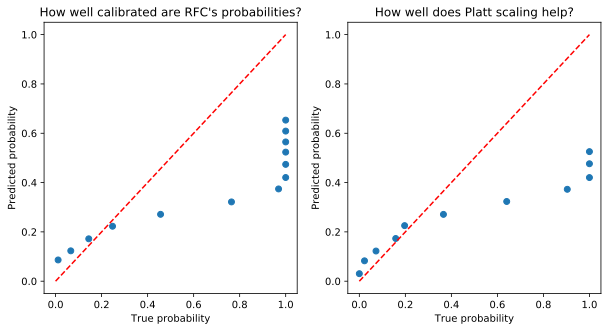

In [27]:
#ignore
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
predict_prob = grid.predict_proba(X_train)[:, 1]
prob_true, prob_predict = calibration_curve(y_train, predict_prob, n_bins=20)

plt.plot(prob_true, prob_predict, 'o')
plt.plot([0,1], [0, 1], 'r--')

plt.xlabel('True probability')
plt.ylabel('Predicted probability')
plt.title('How well calibrated are RFC\'s probabilities?');


plt.subplot(1,2,2)
predict_prob = calibrated_rfc.predict_proba(X_train)[:, 1]
prob_true, prob_predict = calibration_curve(y_train, predict_prob, n_bins=20)
plt.plot(prob_true, prob_predict, 'o')
plt.plot([0,1], [0, 1], 'r--')

plt.xlabel('True probability')
plt.ylabel('Predicted probability')
plt.title('How well does Platt scaling help?');

We see that the recalibration _helps_, but the results are not perfect. In this case, whenever the model makes a prediction of 40% or higher (even after calibration), we are seeing that 100% of the cases are defaults! 

The Platt scaling basically fits a logistic regression on the original model's `predict_proba`. The closer the calibration curve is to a sigmoid, the more effective the scaling will be in correcting the model. You can read more about how it works, and the difference between "sigmoid" and "isotonic" methods in the official [user guide](https://scikit-learn.org/stable/modules/calibration.html).

## Different model performances

So which models have "good" probabilities, and which ones are just "scores". Logistic regression optimizes for the log-loss directly, so it's probabilities are generally well calibrated. For the other models:

| Model | Bias |
| --- | --- |
| **Naive Bayes** | Tends to push probabilties toward the extremes. In this case, the extremes are not 0 or 1, but there is a lot of "pile up" at 0 and 0.7 |
| **Ensembles (e.g. random forest)** | When voting, it is hard to get a probability close to zero or close to 1. A probability of zero would mean each member of the ensemble voted "no", which is unlikely in a large number of ensembles. |
| **LinearSVC** | Support Vector Classifiers generally don't support `predict_proba` in Scikit-learn. The exception is the LinearSVC (i.e. specializing a SVC to a linear kernel). According to the [user guide](https://scikit-learn.org/stable/modules/calibration.html) (and references therein) maximum margin methods tend to have probabilties cluster around the center. |
| **kNN** | Varies a lot depending on $k$. When $k$ is small, the probabilities tend to be close to 0 or 1. As $k$ increases, the probabilites tend to cluster around the middle. |

## Summary

* Soft classification gives scores, where a higher score for that class means the model is more confident in its prediction.
* For binary classification, you only need one score (generally the score of the positive class).
* A probability can be used as a score (even in the multiclass case).
* Many Scikit-learn models, such as Tree-based methods, ensemble methods, kNN, and Naive Bayes have a `predict_proba` method; but these should really be thought of as giving scores rather than "true" probabilities.
* A calibration curve is a good way to check if your probabilities are accurate.
* Platt Scaling is a way of trying to recalibrate your model's probabilities to be probabilities (rather than scores), but you should check calibration after fitting.

The `predict_proba` is a bad name, but as Phil Karlton (a designer for Netscape) once told us:
>There are only two hard things in Computer Science: cache invalidation and naming things.
>
>-- Phil Karlton